In [1]:
from functools import reduce
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict
import torch
from torchvision import models
import numpy as np
from skimage import io
from pytorch_toolbelt.utils.rle import rle_decode
import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import annotation2mask

np.random.seed(0)

## Links to tutorials
- Torchvision maskrcnn inputting: [pytorch.org](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
- Kaggle baseline notebook: [kaggle.com](https://www.kaggle.com/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-273)


In [2]:
# Global config of dataset, not tunable parameters
config = EasyDict(
    dataset_path=Path("/data/kaggle_data/"),
    val_size=0.2,
    batch_size=2,
    num_workers=0,
)

In [3]:
# pascal_voc - inputting bbox coord in format (xmin, ymin, xmax, ymax)
valid_transform = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    A.ShiftScaleRotate(shift_limit=0.8),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))


def get_box(mask):
    """ Get the bounding box of a given mask """
    y_coords, x_coords = np.where(mask)
    xmin = np.min(x_coords)
    xmax = np.max(x_coords)
    ymin = np.min(y_coords)
    ymax = np.max(y_coords)
    return [xmin, ymin, xmax, ymax]


class CellDataset(Dataset):
    def __init__(self, cfg: EasyDict, mode: str, transform: A.Compose = None):
        assert mode == 'train' or mode == 'test'

        self.transform = transform
        self.image_folder = cfg.dataset_path / "train"

        data_csv = pd.read_csv(cfg.dataset_path / "train.csv")
        data_csv = data_csv[['id', 'annotation', 'cell_type']]
        data_csv = data_csv.groupby(['id', 'cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()

        # Now data_csv has 606 rows with 3 columns:
        # - id - id of image,
        # - cell_type - type of cell,
        # - annotation - list of rle strings
        if mode == 'train':
            self.data_csv, _ = train_test_split(data_csv, test_size=cfg.val_size, random_state=0)
        else:
            _, self.data_csv = train_test_split(data_csv, test_size=cfg.val_size, random_state=0)

    def __getitem__(self, item):
        # TODO: Test how much time does .iloc take
        # if I (maxim) am not mistaken, that can be quite long
        image_id, _, annotations = self.data_csv.iloc[item]
        image_path = self.image_folder / (image_id + ".png")
        image = io.imread(str(image_path))

        # TODO: consider using rle_decode instead of annotation2mask
        masks = list(map(lambda line: annotation2mask(line), annotations))
        boxes = list(map(lambda mask: get_box(mask), masks))
        labels = list(map(lambda _: 1, masks))

        if self.transform:
            transformed = self.transform(image=image, masks=masks, bboxes=boxes, category_ids= labels)

            image = transformed['image']
            masks = transformed['masks']
            boxes = transformed['bboxes']

        boxes = np.asarray(boxes)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Training on all samples (setting iscrown=False)
        iscrowd = torch.zeros((len(masks),), dtype=torch.int64)

        target = {
            'masks': torch.as_tensor(masks),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'boxes': torch.as_tensor(boxes),
            'iscrowd': iscrowd,
            'area': torch.as_tensor(area),
            'image_id': image_id,  # For logging purposes
        }


        return image, target

    def __len__(self):
        return len(self.data_csv)

In [4]:
plt.rcParams["figure.figsize"] = (30, 30)

def visualize_dataset(im, boxes, masks):
    """
    Visualization instance of dataset after augmentation
    """
    # torch image preprocessed for plotting with matplotlib
    im = np.transpose(im.numpy(), axes=(1, 2, 0))
    im = (im - im.min()) / (im.max() - im.min())
    im = np.asarray(im * 256., dtype=np.uint8)

    image_mask = reduce(lambda x, y: x + y, masks)

    image_mask[image_mask > 1] = 1
    yellow_mask = np.stack([image_mask, image_mask, np.zeros_like(image_mask)], axis=2)

    image_with_mask = np.array(im + 50 * yellow_mask, dtype=np.uint8)

    # Drawing red rectangle for each instances
    red_color = (255, 0, 0)
    for x1, y1, x2, y2 in boxes:
        image_with_mask = cv2.rectangle(image_with_mask.copy(), pt1=(int(x1), int(y1)), pt2=(int(x2), int(y2)), color=red_color, thickness=2)
    
    plt.imshow(image_with_mask)
    plt.xticks([])
    plt.yticks([])
    plt.show()

/tmp/ipykernel_15451/100910077.py:65: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/torch/csrc/utils/tensor_new.cpp:201.)
  'masks': torch.as_tensor(masks),


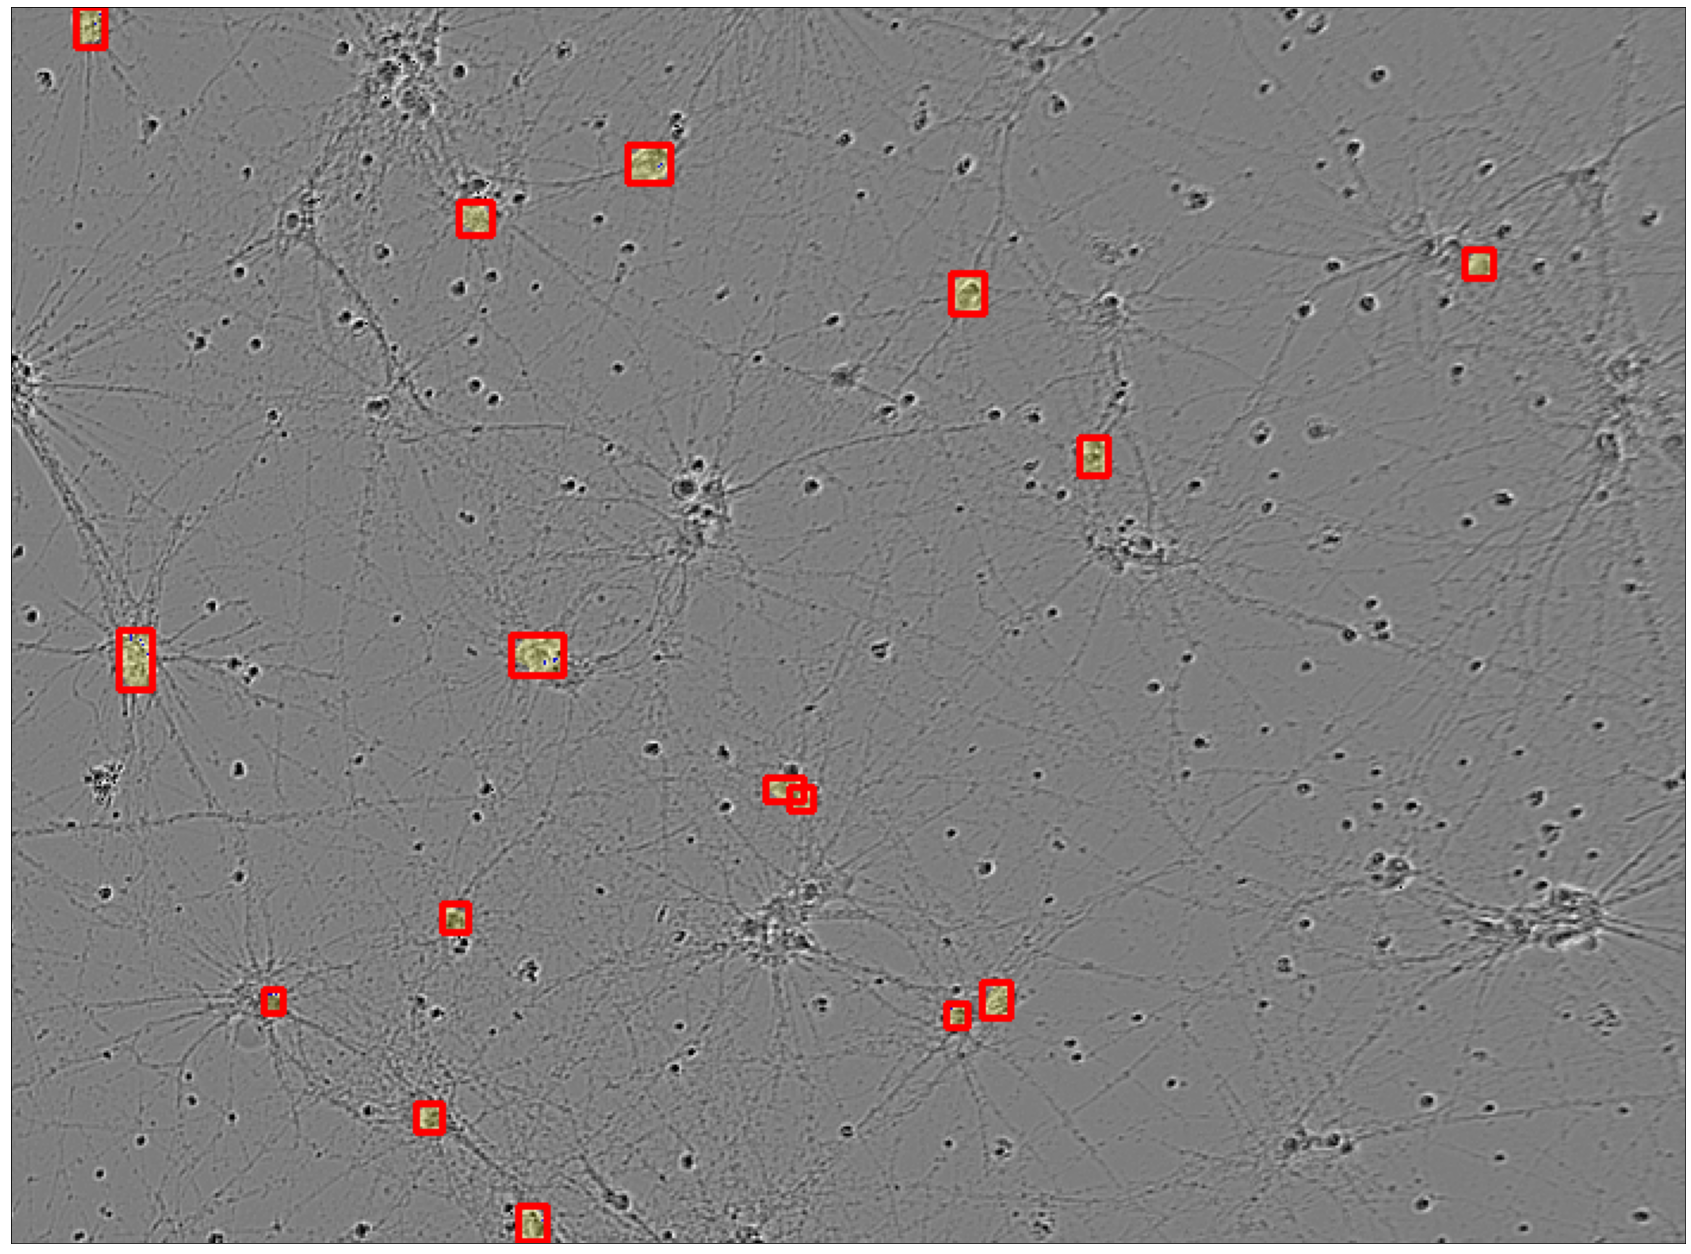

In [5]:
dataset = CellDataset(cfg=config, mode='train', transform=valid_transform)

image, data = dataset[1]
visualize_dataset(image, boxes=data['boxes'], masks=data['masks'])

In [6]:
# Do not change collate function - it was takes from torchvision tutorials
dataloader = DataLoader(dataset=CellDataset(cfg=config, mode='train', transform=valid_transform),
                        num_workers=config.num_workers,
                        batch_size=config.batch_size,
                        collate_fn=lambda x: tuple(zip(*x)))

# 2 classes: 0 - background, 1 - cell
model = models.detection.maskrcnn_resnet50_fpn(num_classes=2, progress=False)
model.train()

for image, label in dataloader:
    output = model(image, label)
    print(f"output: {output}")
    break

/conda/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


output: {'loss_classifier': tensor(0.7736, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0558, grad_fn=<DivBackward0>), 'loss_mask': tensor(7.4564, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.7037, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.4296, dtype=torch.float64, grad_fn=<DivBackward0>)}
